## RBM's in Pytorch

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn.functional
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
import ising_analysis
import importlib
importlib.reload(ising_analysis)

<module 'ising_analysis' from '../ising_analysis.py'>

In [3]:
# Turn debuggers off once model is... debugged
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [4]:
# Set pytorch random seed
torch.manual_seed(0)

## Define the model

Energy:
\begin{equation}
E(\sigma,h) = -\sum_{i,j,\alpha} W_{(i-j),\alpha} \sigma_i h_{j,\alpha} -B \sum_i \sigma_i -\sum_{j,\alpha} c_{\alpha} h_{j,\alpha}
\end{equation}

Free energy:
\begin{equation}
\varepsilon(\sigma) = -B \sum_{i=1}^{N} \sigma_i -\sum_{\alpha=1}^M \sum_{j=1}^{N} \ln (1+e^{c_{\alpha}+\sum_{i=1}^{N}W_{(i-j),\alpha}\sigma_i})
\end{equation}

$L$: linear size

$N$: total spins

$M$: hidden neurons per spin

$\sigma_i$: spin unit

$h_{j,\alpha}$: hidden unit

$W_{(i-j),\alpha}$: weight

$i,j \in [0,N-1]$

$\alpha \in [0,M-1]$

In [5]:
# Define model
class RBM(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return torch.nn.functional.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v):
        p_h = torch.sigmoid(torch.nn.functional.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = torch.sigmoid(torch.nn.functional.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = torch.nn.functional.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [6]:
# Create Ising Dataset object from Monte Carlo data
class CustomIsingDataset(Dataset):
    def __init__(self,spins):
        self.spins = spins
        
    def __len__(self):
        return len(self.spins)
    
    def __getitem__(self,idx):
        spins = self.spins[idx]
        sample = {'spins': spins}
        return sample

In [7]:
# Specify the linear size and temperature
L = 8
T = 4.0

In [8]:
# Load spin data
filename_mc_spins = '../uncorrelated_monte_carlo_data/L_'+str(L)+'_T_'+str(T)+'_spins_seed_0.dat'

# Load data from file
spins = np.loadtxt(filename_mc_spins,dtype=np.float32) # network training sometimes breaks for 'double'

# Convert -1's to 0's for RBM compatibility
spins[spins==-1] = 0

# Convert to Python list for dataframe promotion simplicity
spins = list(spins)

# Convert spin data to pandas dataframe
spins_df = pd.DataFrame({'spins':spins})

# Create Dataset object
spins_dataset = CustomIsingDataset(spins_df['spins'])

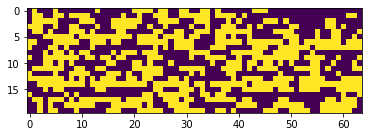

In [9]:
# Show first few rows of loaded Monte Carlo configurations
plt.imshow(spins[0:20])

## Check Monte Carlo data

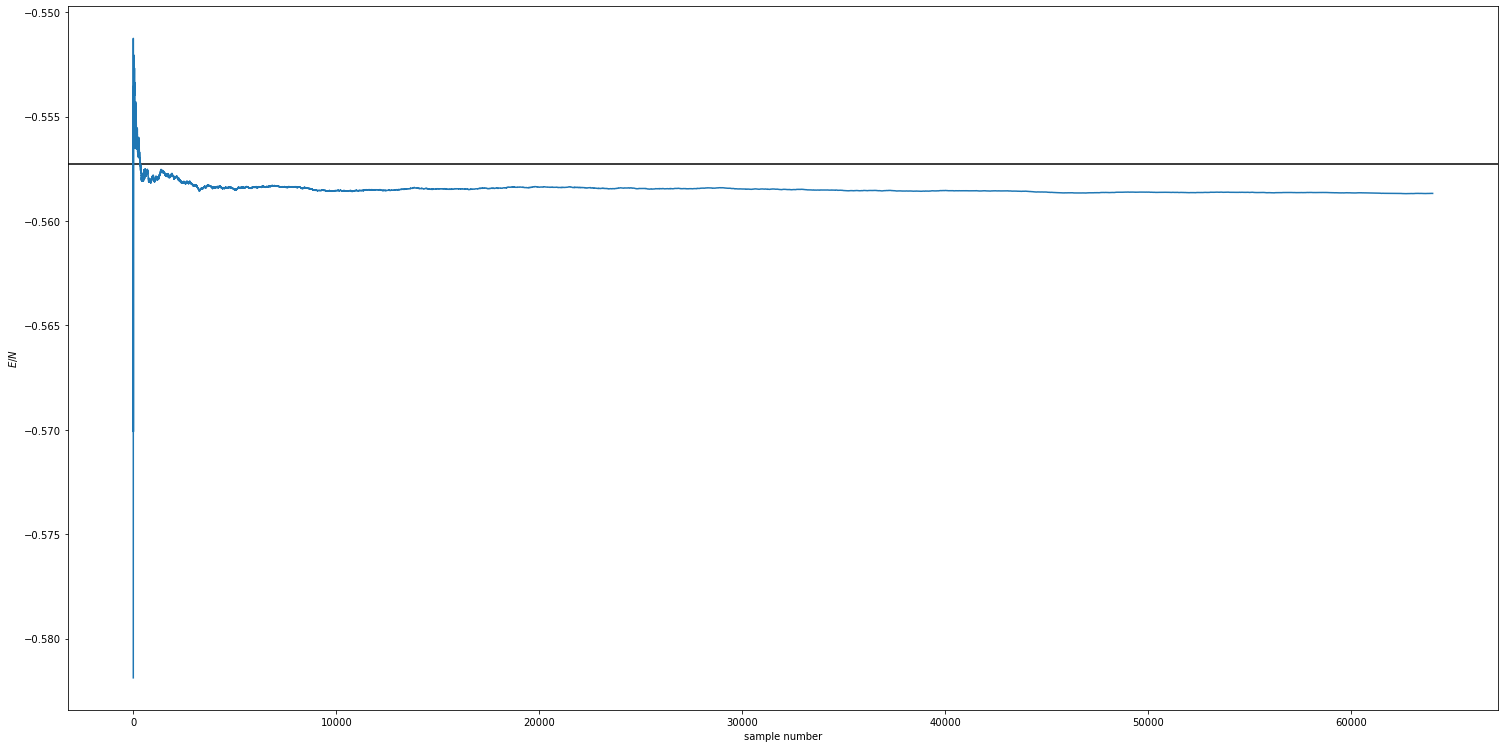

In [34]:
filename_mc = '../uncorrelated_monte_carlo_data/L_'+str(L)+'_T_'+str(T)+'_seed_0.dat'

mc_data = np.loadtxt(filename_mc)
mc_e = mc_data[:,0] / L**2

# Plot running average of energy per spin
plt.plot(np.arange(mc_e.shape[0]),np.cumsum(mc_e)/np.arange(1,mc_e.shape[0]+1),color='tab:blue')

plt.xlabel('sample number')
plt.ylabel(r'$E/N$')
plt.axhline(ising_analysis.e_exact_func(T),zorder=-1,color='k')

../ising_analysis.py:103: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(1-np.tanh(K)**2)**4/(16*np.tanh(K)**4))**(1/8)


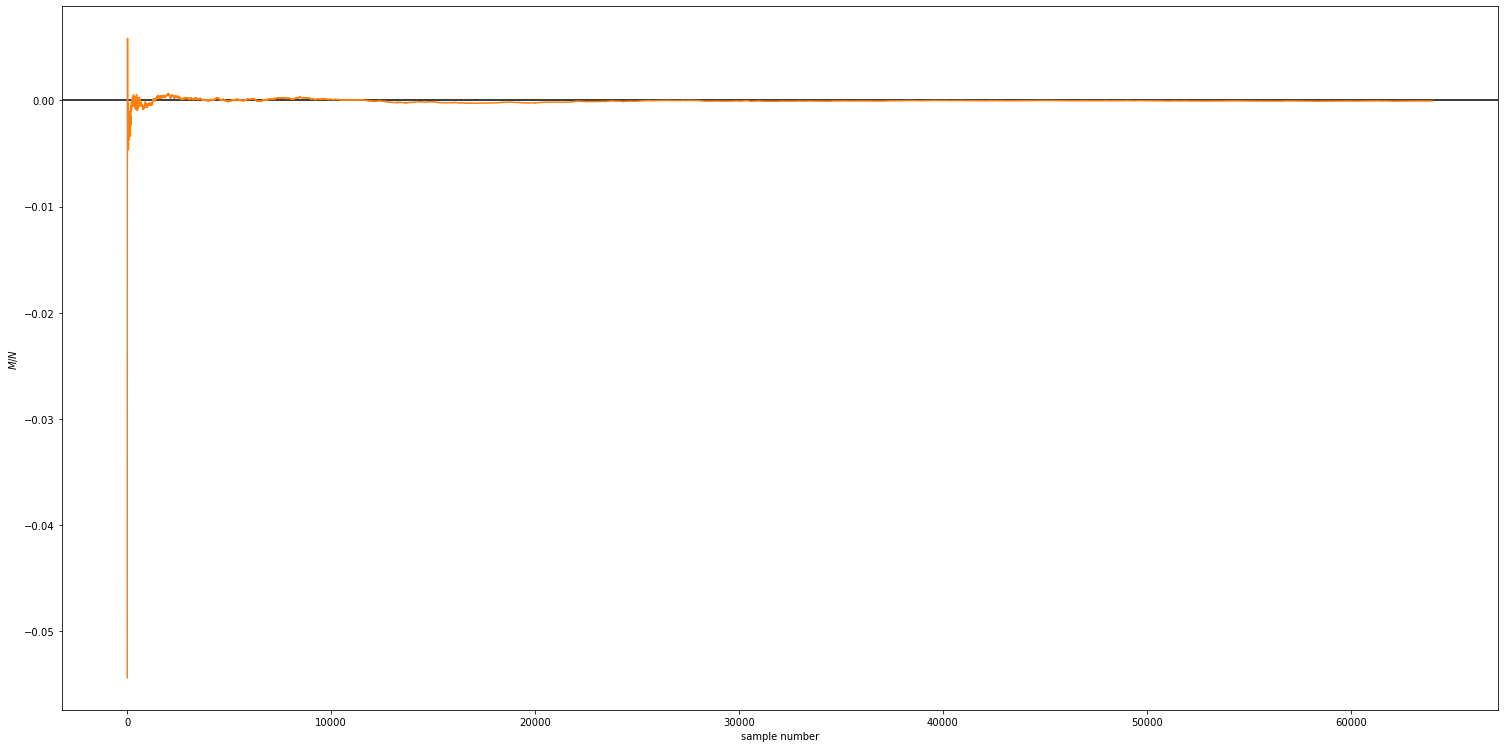

In [35]:
mc_m = mc_data[:,1] / L**2

# Plot running average of energy per spin
plt.plot(np.arange(mc_m.shape[0]),np.cumsum(mc_m)/np.arange(1,mc_m.shape[0]+1),color='tab:orange')

plt.xlabel('sample number')
plt.ylabel(r'$M/N$')
plt.axhline(np.nan_to_num(ising_analysis.m_exact_func(T)),zorder=-1,color='k')

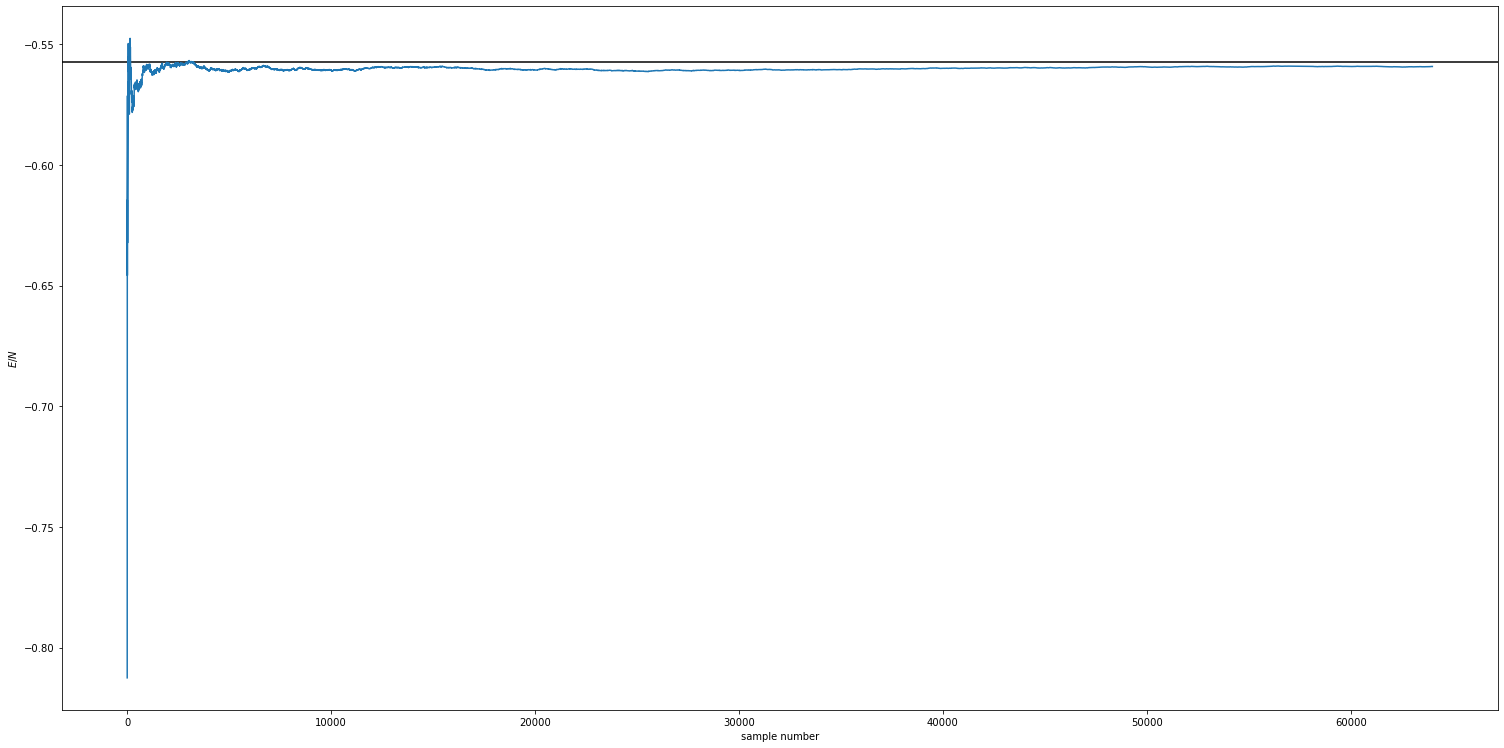

In [36]:
spins_data = np.loadtxt(filename_mc_spins)
mc_e = np.zeros(spins_data.shape[0])

for i,config in enumerate(spins_data):
    
    # print(config)
    ising_lattice = config.reshape((L,L))
    
    mc_e[i] = ising_analysis.get_energy(ising_lattice,L)
    
mc_e /= L**2
 
# Plot running average of energy per spin
plt.plot(np.arange(mc_e.shape[0]),np.cumsum(mc_e)/np.arange(1,mc_e.shape[0]+1),color='tab:blue')

plt.xlabel('sample number')
plt.ylabel(r'$E/N$')
plt.axhline(ising_analysis.e_exact_func(T),zorder=-1,color='k')

../ising_analysis.py:103: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(1-np.tanh(K)**2)**4/(16*np.tanh(K)**4))**(1/8)


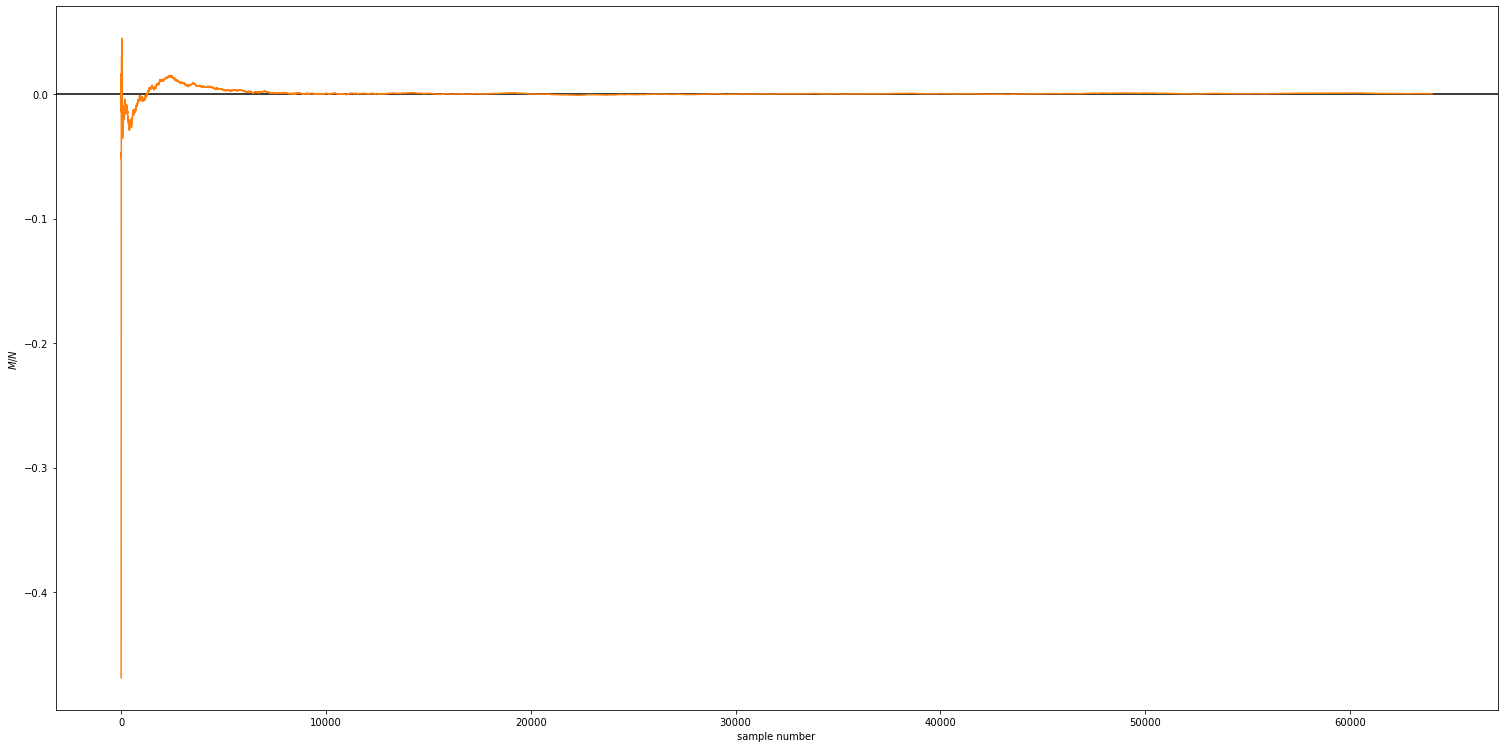

In [37]:
spins_data = np.loadtxt(filename_mc_spins)
mc_m = np.zeros(spins_data.shape[0])

for i,config in enumerate(spins_data):
    
    # print(config)
    ising_lattice = config.reshape((L,L))
    
    mc_m[i] = ising_analysis.get_magnetization(ising_lattice,L)
    
mc_m /= L**2
 
# Plot running average of energy per spin
plt.plot(np.arange(mc_m.shape[0]),np.cumsum(mc_m)/np.arange(1,mc_m.shape[0]+1),color='tab:orange')

plt.xlabel('sample number')
plt.ylabel(r'$M/N$')
plt.axhline(np.nan_to_num(ising_analysis.m_exact_func(T)),zorder=-1,color='k')

## Perform train/test split of full dataset

In [14]:
N_full = len(spins_dataset) # total length of full dataset
N_train = int(N_full*1.0)
N_test = N_full - N_train

print("Full set: ", N_full,'\n')
print("Train set: ", N_train)
print("Test set: ", N_test,'\n')

# To use random_split(), lengths of train/test sets must add up to full. Check.
if (N_train + N_test == N_full): print('Good! Length of splitted sets adds up to full length.') 

Full set:  64000 

Train set:  64000
Test set:  0 

Good! Length of splitted sets adds up to full length.


In [15]:
# Perform random non-overlapping train/test split
train_spins,test_spins = torch.utils.data.random_split(spins_dataset,[N_train,N_test])

## Initialize and train the model

In [16]:
# Network hyperparamters
N_spins = L**2
n_vis = N_spins
n_hin = N_spins

In [17]:
n_hin

64

In [19]:
%%time

# Training parameters
epochs = 100000
η = 0.01
batch_size = 50

# Define train and test DataLoaders
train_loader = DataLoader(train_spins, batch_size=batch_size, shuffle=True, num_workers=0)

rbm = RBM(n_vis,n_hin,k=1)
train_op = optim.SGD(rbm.parameters(),η)

loss_at_epoch = []
epoch = 0
counter = 0

# free_energy_old = 
for epoch in range(epochs):
    loss_ = []
    for idx, data in enumerate(train_loader): # iterates over batch
        
        sample_data = data['spins']
        # sample_data = Variable(data.view(-1,n_vis)) # This is like a np.reshape(), might be unnecessary
        
        counter += 1
        v,v1 = rbm(sample_data) # v: input, v1: generated
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    
    mean_loss = np.mean(loss_)
    loss_at_epoch.append(np.mean(loss_)) # might need to loss_.detach()
    if epoch%100 == 0:
        print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
    epoch += 1
print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

Training loss for 0 epoch: 0.023784860968589783
Training loss for 100 epoch: -0.24042761325836182
Training loss for 200 epoch: -0.10502483695745468
Training loss for 300 epoch: -0.057470958679914474
Training loss for 400 epoch: -0.03668207675218582
Training loss for 500 epoch: -0.03427917882800102
Training loss for 600 epoch: 0.006531369872391224
Training loss for 700 epoch: -0.0023175477981567383
Training loss for 800 epoch: 0.02407231368124485
Training loss for 900 epoch: 0.01639491878449917
Training loss for 1000 epoch: 0.017277169972658157
Training loss for 1100 epoch: 0.027237068861722946
Training loss for 1200 epoch: 0.028573358431458473
Training loss for 1300 epoch: 0.015477145090699196
Training loss for 1400 epoch: 0.023131847381591797
Training loss for 1500 epoch: 0.021183902397751808
Training loss for 1600 epoch: 0.018669206649065018
Training loss for 1700 epoch: 0.016170715913176537
Training loss for 1800 epoch: 0.04323752969503403
Training loss for 1900 epoch: 0.02224927581

KeyboardInterrupt: 

In [22]:
len(loss_)

1063

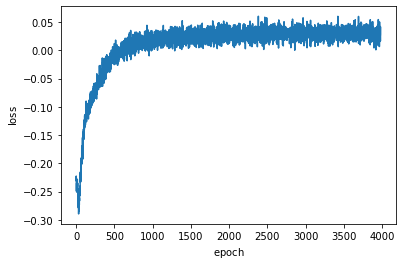

In [23]:
# Plot loss function
loss_at_epoch = np.array(loss_at_epoch)
plt.plot(range(len(loss_at_epoch[50:])),loss_at_epoch[50:])
# plt.yscale('log')
plt.xlabel(r'$\rm epoch$')
plt.ylabel(r'$\rm loss$');

## Training saturated at 0.5. Need to lower. 

The network is now trained (seemingly).

In [24]:
torch.save(rbm.state_dict(),'./L_'+str(L)+'_T_'+str(T)+'_nonsymmRBM.pt')

In [18]:
rbm = RBM(n_vis,n_hin,k=1)
# rbm.load_state_dict(torch.load('./L_6_T_4.0_nonsymmRBM.pt'))
rbm.load_state_dict(torch.load('./L_'+str(L)+'_T_'+str(T)+'_nonsymmRBM.pt'))
rbm.eval()

RBM()

## Sampling Ising configurations from model

With our trained model, we now want to sample a new set of Ising configuraions according to the model probability distribution.

### Plot random walk

In [19]:
num_walks = 12 # number of independent random walks desired when sampling 

In [20]:
v_in = torch.bernoulli(torch.rand(num_walks,n_vis))

In [26]:
%%time

files = []
filenames = []
for w in range(num_walks):
    # Open file for writing
    filename = 'L_'+str(L)+'_T_'+str(T)+'_rbm_walk_'+str(w)+'.dat'
    file = open(filename, "w")
    header = "#L=%d, T=%.2f \n# E     M \n"
    file.write(header)
    files.append(file)
    filenames.append(filename)

# Initialize quantities to measure
E = np.zeros(num_walks)
M = np.zeros(num_walks)

# Set simulation parameters
bins_wanted = 1000 # number of samples to generate
# sweep = L**2 # size of one Monte Carlo sweep
sweep = 1 # size of one Monte Carlo sweep
bin_size = 5 # number of samples  to 
skip = 80 # sweeps performed between measurement

equilibration_steps = 5000

bins_written = 0 # counts how many bins have been written to disk
measurement_ctr = 0 # to track if we can write to disk
m = 0 # iteration counter
while(bins_written<bins_wanted):
    
    m +=1
    
    # Update input and generated visible vector
    v_in, v_gen = rbm(v_in.view(-1, N_spins))
    # v_in.
    # v_in = v_gen
    
    v_in = v_in.detach()
    v_gen =v_gen.detach()
    v_in = v_gen
    
    # Perform measurement
    if (m%(sweep*skip)==0 and m>equilibration_steps):
        
        # Unflatten and replace 0's with -1's
        ising_lattice = v_gen.detach().numpy().reshape((num_walks,L,L))

        ising_lattice[ising_lattice==0] = -1
        
        for w in range(num_walks):
            E[w] += ising_analysis.get_energy(ising_lattice[w],L)
            M[w] += ising_analysis.get_magnetization(ising_lattice[w],L)
        
        measurement_ctr += 1
        
        if (measurement_ctr==bin_size):
            
            # Write to disk
            for w in range(num_walks):
                files[w].write('%.2f %.2f \n'%(E[w]/bin_size,M[w]/bin_size))
            
            bins_written += 1
        
            # Reset counters and accumulators
            measurement_ctr = 0
            E = np.zeros(num_walks)
            M = np.zeros(num_walks)

            if bins_written%1000==0:
                print("bins_written: ",bins_written)
            
# Close files           
for w in range(num_walks):
    files[w].close()

bins_written:  1000
CPU times: user 1min 12s, sys: 259 ms, total: 1min 12s
Wall time: 1min 12s


In [27]:
# plt.rcParams["figure.figsize"] = [7.00*2, 3.50*2]
# plt.rcParams["figure.autolayout"] = True

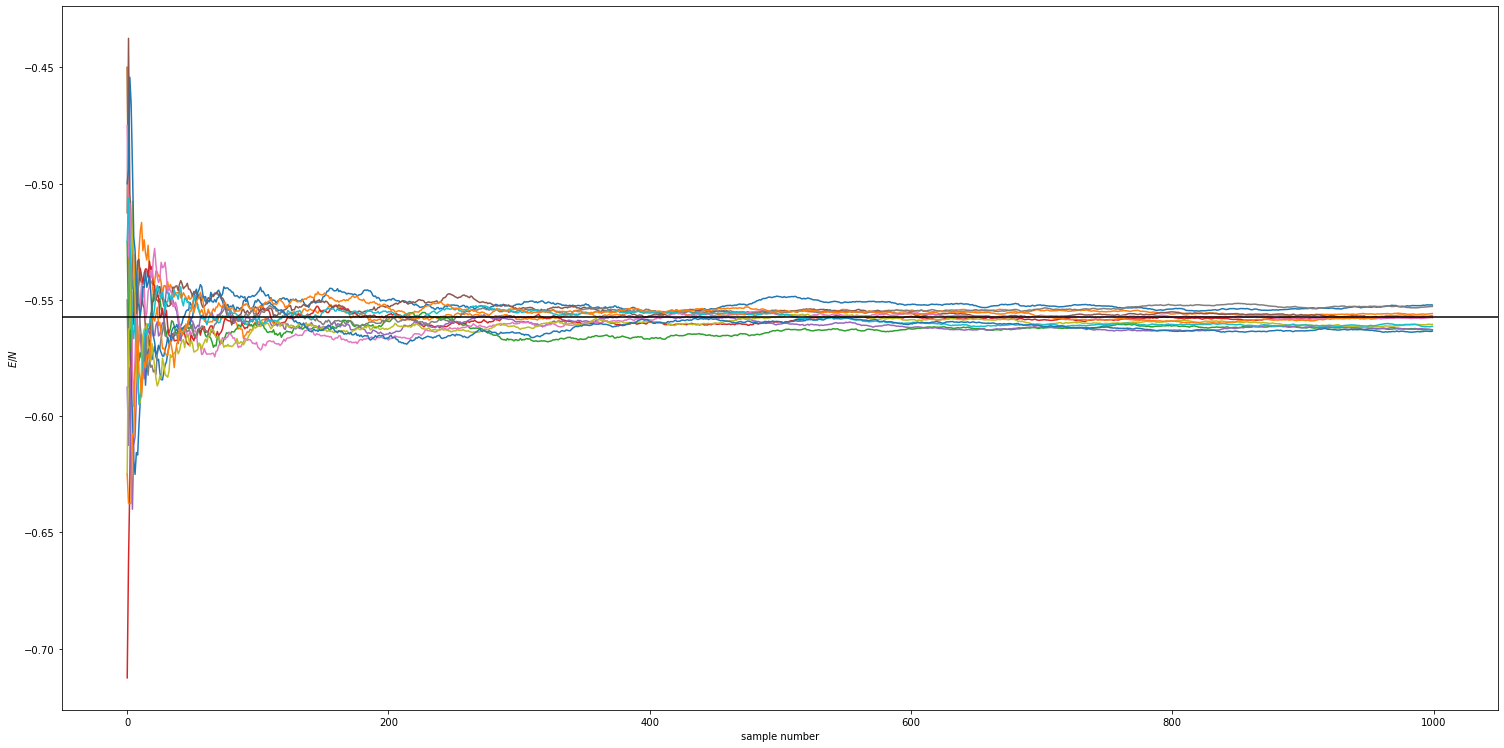

In [33]:
for w in range(num_walks):
    
    filename = 'L_'+str(L)+'_T_'+str(T)+'_rbm_walk_'+str(w)+'.dat'

    rbm_data = np.loadtxt(filename)
    rbm_E = rbm_data[:,0]
    rbm_M = rbm_data[:,1]

    rbm_e = rbm_E/L**2
    rbm_m = rbm_M/L**2
    
    # Plot running average of energy per spin
    plt.plot(np.arange(rbm_e.shape[0]),np.cumsum(rbm_e)/np.arange(1,rbm_e.shape[0]+1))

plt.xlabel('sample number')
plt.ylabel(r'$E/N$')

plt.axhline(ising_analysis.e_exact_func(T),zorder=5,color='k')
# plt.savefig('e_without_abs.pdf',dpi=300)

../ising_analysis.py:103: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(1-np.tanh(K)**2)**4/(16*np.tanh(K)**4))**(1/8)


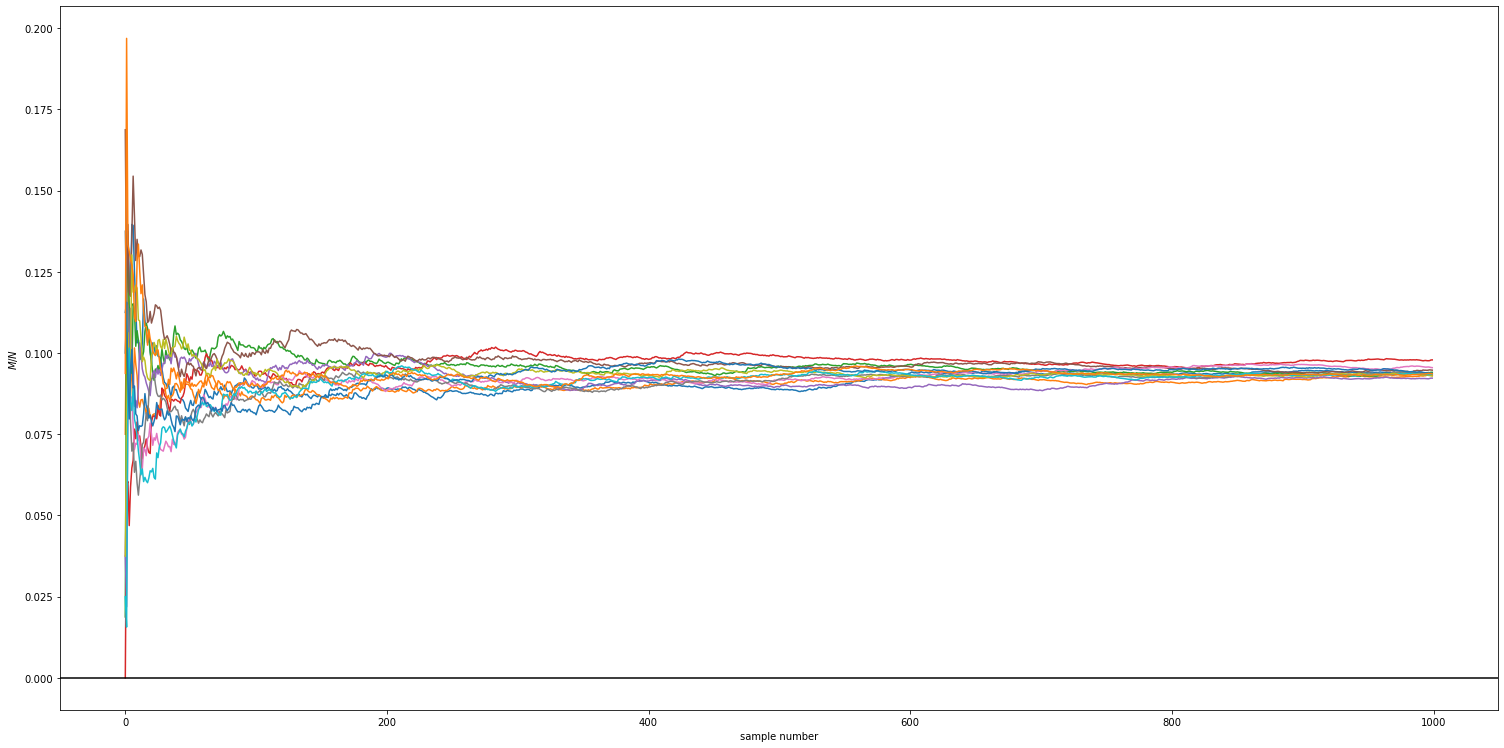

In [38]:
for w in range(num_walks):
    
    filename = 'L_'+str(L)+'_T_'+str(T)+'_rbm_walk_'+str(w)+'.dat'

    rbm_data = np.loadtxt(filename)
    rbm_M = rbm_data[:,1]

    rbm_m = np.abs(rbm_M)/L**2
    
    # Plot running average of energy per spin
    plt.plot(np.arange(rbm_m.shape[0]),np.cumsum(rbm_m)/np.arange(1,rbm_m.shape[0]+1))

plt.xlabel('sample number')
plt.ylabel(r'$M/N$')

plt.axhline(np.nan_to_num(ising_analysis.m_exact_func(T)),zorder=5,color='k')
# plt.savefig('e_without_abs.pdf',dpi=300)

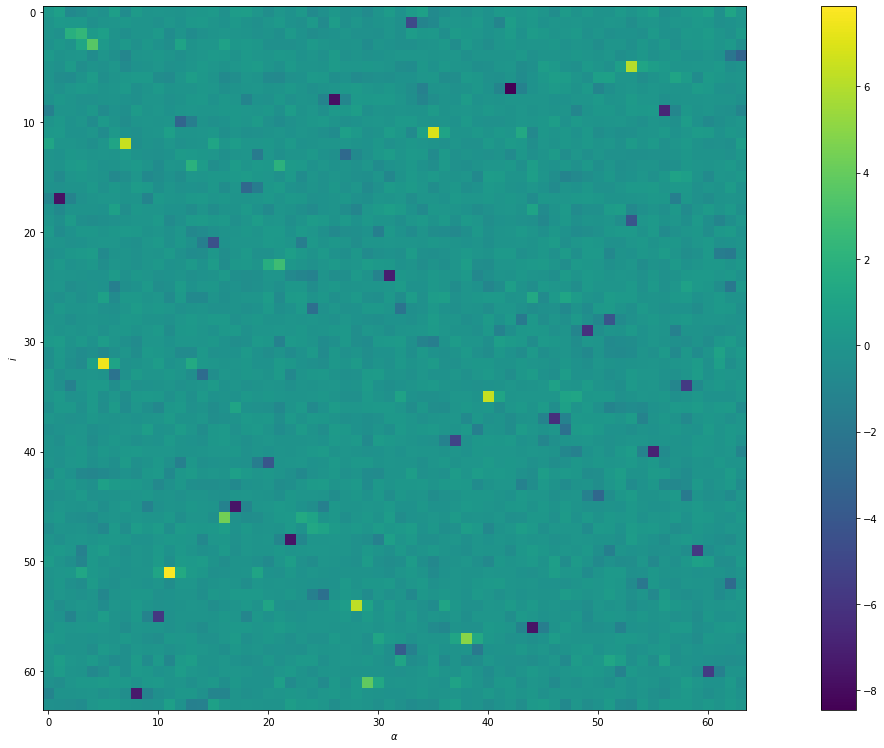

In [39]:
plt.rcParams["figure.figsize"] = [7.00*3, 3.50*3]
plt.rcParams["figure.autolayout"] = True
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$i$')
plt.imshow(rbm.W.detach().numpy())
plt.colorbar()
# plt.clim(0,1)

# References

https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

https://stats.stackexchange.com/questions/114844/how-to-compute-the-free-energy-of-a-rbm-given-its-energy

https://github.com/lisa-lab/DeepLearningTutorials/blob/master/code/rbm.py#L127

https://medium.com/machine-learning-researcher/boltzmann-machine-c2ce76d94da5